In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

In [4]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = len(data_input[:, 0, 0, 0])
    model.eval()
    print('data_target', data_target.shape)
    print('data_input', data_input.shape)
    
    for b_start in range(0, Ndata, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='125Hz', window=True,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='125Hz', window=True,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (18300, 28, 8)
test (6100, 28, 8)
validation (976, 28, 8)
Ntrain =  18300
Ntest =  6100
Nvalidation =  976


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(50))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs) #from PdM
    model = conv2DNet_6(Noutputs)
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  0
	 Training accuracy:  63.28415300546448
	 Validation accuracy  52.76639344262295
	 Test accuracy  56.90163934426229
	 Epoch Loss  771.6889038085938
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  1
	 Training accuracy:  72.26229508196721
	 Validation accuracy  60.65573770491803
	 Test accuracy  56.704918032786885
	 Epoch Loss  668.82421875
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  2
	 

Epoch Number :  21
	 Training accuracy:  90.02732240437159
	 Validation accuracy  55.635245901639344
	 Test accuracy  46.73770491803279
	 Epoch Loss  31.190170288085938
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  22
	 Training accuracy:  88.06010928961749
	 Validation accuracy  55.122950819672134
	 Test accuracy  47.967213114754095
	 Epoch Loss  40.34190368652344
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  23
	 Training accuracy:  90.08743169398907
	 Validation accuracy  50.10245901639344
	 Test accuracy  46.18032786885246
	 Epoch Loss  60.49391555786133
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  43
	 Training accuracy:  91.60109289617486
	 Validation accuracy  49.385245901639344
	 Test accuracy  47.21311475409836
	 Epoch Loss  18.51148223876953
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  44
	 Training accuracy:  91.55737704918033
	 Validation accuracy  50.0
	 Test accuracy  47.67213114754098
	 Epoch Loss  15.793169021606445
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  45
	 Training accuracy:  90.51912568306011
	 Validation accuracy  48.05327868852459
	 Test accu

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  15
	 Training accuracy:  88.33879781420765
	 Validation accuracy  49.385245901639344
	 Test accuracy  51.0655737704918
	 Epoch Loss  64.1166763305664
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  16
	 Training accuracy:  87.96174863387978
	 Validation accuracy  45.1844262295082
	 Test accuracy  46.704918032786885
	 Epoch Loss  65.05835723876953
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  17
	 Trainin

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  37
	 Training accuracy:  89.11475409836065
	 Validation accuracy  48.97540983606557
	 Test accuracy  44.42622950819672
	 Epoch Loss  36.64767837524414
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  38
	 Training accuracy:  89.43169398907104
	 Validation accuracy  43.75
	 Test accuracy  47.65573770491803
	 Epoch Loss  29.87310218811035
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  39
	 Training accuracy:

Epoch Number :  8
	 Training accuracy:  87.27868852459017
	 Validation accuracy  51.127049180327866
	 Test accuracy  48.09836065573771
	 Epoch Loss  140.71124267578125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  9
	 Training accuracy:  83.5464480874317
	 Validation accuracy  51.22950819672131
	 Test accuracy  52.032786885245905
	 Epoch Loss  124.76229858398438
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  10
	 Training accuracy:  88.12021857923497
	 Validation accuracy  51.94672131147541
	 Test accuracy  48.885245901639344
	 Epoch Loss  111.06362915039062
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  30
	 Training accuracy:  90.15300546448087
	 Validation accuracy  46.41393442622951
	 Test accuracy  50.0655737704918
	 Epoch Loss  44.63032531738281
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  31
	 Training accuracy:  91.52459016393442
	 Validation accuracy  45.69672131147541
	 Test accuracy  48.14754098360656
	 Epoch Loss  35.128501892089844
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  32
	 Training accuracy:  88.68306010928961
	 Validation accuracy  34.631147540983605

Epoch Number :  1
	 Training accuracy:  73.27322404371584
	 Validation accuracy  52.049180327868854
	 Test accuracy  55.0
	 Epoch Loss  630.197021484375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  2
	 Training accuracy:  79.3879781420765
	 Validation accuracy  46.721311475409834
	 Test accuracy  52.278688524590166
	 Epoch Loss  471.0578918457031
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  3
	 Training accuracy:  79.19672131147541
	 Validation accuracy  56.25
	 Test accuracy  51.65573770491803
	 Epoch Loss  358.5329895019531
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976

data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  23
	 Training accuracy:  86.90710382513662
	 Validation accuracy  40.471311475409834
	 Test accuracy  51.85245901639344
	 Epoch Loss  34.85045623779297
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  24
	 Training accuracy:  90.49180327868852
	 Validation accuracy  46.51639344262295
	 Test accuracy  47.90163934426229
	 Epoch Loss  49.19239044189453
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  25
	 Training accuracy:  87.20765027322405
	 Validation accuracy  53.99590163934426
	 Test accuracy  50.21311475409836
	 Epoch Loss  36.215885162353516


data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  45
	 Training accuracy:  92.64480874316939
	 Validation accuracy  51.63934426229508
	 Test accuracy  47.59016393442623
	 Epoch Loss  4.292806625366211
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  46
	 Training accuracy:  92.8360655737705
	 Validation accuracy  52.25409836065574
	 Test accuracy  47.442622950819676
	 Epoch Loss  2.912616729736328
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  47
	 Traini

Epoch Number :  16
	 Training accuracy:  87.40437158469945
	 Validation accuracy  47.028688524590166
	 Test accuracy  49.950819672131146
	 Epoch Loss  55.08356475830078
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  17
	 Training accuracy:  88.75409836065573
	 Validation accuracy  54.30327868852459
	 Test accuracy  51.295081967213115
	 Epoch Loss  63.73828887939453
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  18
	 Training accuracy:  88.10382513661202
	 Validation accuracy  47.33606557377049
	 Test accuracy  50.721311475409834
	 Epoch Loss  75.31391143798828
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  38
	 Training accuracy:  90.53551912568307
	 Validation accuracy  50.10245901639344
	 Test accuracy  52.31147540983606
	 Epoch Loss  18.171194076538086
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  39
	 Training accuracy:  90.98360655737704
	 Validation accuracy  52.25409836065574
	 Test accuracy  50.49180327868852
	 Epoch Loss  48.7027702331543
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  40
	 Training accuracy:  90.81420765027322
	 Validation accuracy  48.05327868852459


data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  10
	 Training accuracy:  86.77049180327869
	 Validation accuracy  44.467213114754095
	 Test accuracy  51.50819672131148
	 Epoch Loss  104.20882415771484
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  11
	 Training accuracy:  88.25136612021858
	 Validation accuracy  41.39344262295082
	 Test accuracy  48.295081967213115
	 Epoch Loss  111.25874328613281
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  12
	 Tr

Epoch Number :  31
	 Training accuracy:  91.49726775956285
	 Validation accuracy  52.15163934426229
	 Test accuracy  47.47540983606557
	 Epoch Loss  49.9816780090332
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  32
	 Training accuracy:  92.3879781420765
	 Validation accuracy  45.08196721311475
	 Test accuracy  50.0655737704918
	 Epoch Loss  45.350765228271484
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  33
	 Training accuracy:  91.14754098360656
	 Validation accuracy  46.00409836065574
	 Test accuracy  47.377049180327866
	 Epoch Loss  24.326488494873047
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])


data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  3
	 Training accuracy:  81.09836065573771
	 Validation accuracy  55.532786885245905
	 Test accuracy  53.67213114754098
	 Epoch Loss  363.236328125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  4
	 Training accuracy:  82.14754098360656
	 Validation accuracy  54.61065573770492
	 Test accuracy  52.18032786885246
	 Epoch Loss  262.05084228515625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  5
	 Training accuracy:  83.8743169398907
	 Validation accuracy  52.049180327868854
	 Tes

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  25
	 Training accuracy:  89.7431693989071
	 Validation accuracy  50.92213114754098
	 Test accuracy  52.83606557377049
	 Epoch Loss  43.302032470703125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  26
	 Training accuracy:  89.97267759562841
	 Validation accuracy  44.26229508196721
	 Test accuracy  48.52459016393443
	 Epoch Loss  33.106178283691406
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  27
	 Train

Epoch Number :  46
	 Training accuracy:  91.65573770491804
	 Validation accuracy  45.90163934426229
	 Test accuracy  51.278688524590166
	 Epoch Loss  32.41135787963867
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  47
	 Training accuracy:  90.37158469945355
	 Validation accuracy  41.49590163934426
	 Test accuracy  51.83606557377049
	 Epoch Loss  22.750463485717773
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  48
	 Training accuracy:  92.53005464480874
	 Validation accuracy  47.540983606557376
	 Test accuracy  48.83606557377049
	 Epoch Loss  13.890725135803223
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  18
	 Training accuracy:  88.82513661202186
	 Validation accuracy  46.92622950819672
	 Test accuracy  50.9344262295082
	 Epoch Loss  61.24095916748047
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  19
	 Training accuracy:  87.80874316939891
	 Validation accuracy  49.89754098360656
	 Test accuracy  51.52459016393443
	 Epoch Loss  66.0636215209961
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  20
	 Training accuracy:  86.23497267759562
	 Validation accuracy  59.221311475409834
	

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  40
	 Training accuracy:  90.92896174863388
	 Validation accuracy  41.90573770491803
	 Test accuracy  49.80327868852459
	 Epoch Loss  7.02608585357666
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  41
	 Training accuracy:  90.23497267759562
	 Validation accuracy  48.77049180327869
	 Test accuracy  50.295081967213115
	 Epoch Loss  59.79091262817383
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  42
	 Traini

Epoch Number :  11
	 Training accuracy:  86.86338797814207
	 Validation accuracy  56.557377049180324
	 Test accuracy  50.868852459016395
	 Epoch Loss  73.98596954345703
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  12
	 Training accuracy:  85.02732240437159
	 Validation accuracy  59.631147540983605
	 Test accuracy  47.9344262295082
	 Epoch Loss  118.63265228271484
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  13
	 Training accuracy:  88.86338797814207
	 Validation accuracy  53.99590163934426
	 Test accuracy  50.557377049180324
	 Epoch Loss  56.79189682006836
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  33
	 Training accuracy:  82.66120218579235
	 Validation accuracy  44.56967213114754
	 Test accuracy  49.21311475409836
	 Epoch Loss  49.420867919921875
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  34
	 Training accuracy:  91.08743169398907
	 Validation accuracy  42.622950819672134
	 Test accuracy  48.08196721311475
	 Epoch Loss  25.570363998413086
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  35
	 Training accuracy:  88.8743169398907
	 Validation accuracy  50.5122950819672

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  5
	 Training accuracy:  84.92349726775956
	 Validation accuracy  55.02049180327869
	 Test accuracy  49.36065573770492
	 Epoch Loss  224.26370239257812
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  6
	 Training accuracy:  87.59562841530055
	 Validation accuracy  51.4344262295082
	 Test accuracy  50.50819672131148
	 Epoch Loss  188.15792846679688
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  7
	 Training

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  27
	 Training accuracy:  90.29508196721312
	 Validation accuracy  45.90163934426229
	 Test accuracy  49.0655737704918
	 Epoch Loss  41.287139892578125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  28
	 Training accuracy:  91.27322404371584
	 Validation accuracy  46.92622950819672
	 Test accuracy  49.09836065573771
	 Epoch Loss  48.100826263427734
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  29
	 Train

Epoch Number :  48
	 Training accuracy:  92.66120218579235
	 Validation accuracy  44.364754098360656
	 Test accuracy  47.950819672131146
	 Epoch Loss  0.8348202705383301
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  49
	 Training accuracy:  92.63387978142076
	 Validation accuracy  44.467213114754095
	 Test accuracy  48.0655737704918
	 Epoch Loss  0.6759316921234131
Repetition 10
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  0
	 Training accuracy:  65.08743169398907
	 Validation accuracy  57.58196721311475
	 Test accuracy  57.91803278688525
	 Epoch Loss  772.586669921875
data_target torch.Size([18300])
data_input torch.Size([18

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  20
	 Training accuracy:  87.97814207650273
	 Validation accuracy  48.05327868852459
	 Test accuracy  49.36065573770492
	 Epoch Loss  56.839115142822266
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  21
	 Training accuracy:  84.9672131147541
	 Validation accuracy  47.33606557377049
	 Test accuracy  50.295081967213115
	 Epoch Loss  35.25664520263672
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  22
	 Training accuracy:  86.49180327868852
	 Validation accuracy  51.84426229508197

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  42
	 Training accuracy:  89.55191256830601
	 Validation accuracy  52.049180327868854
	 Test accuracy  48.295081967213115
	 Epoch Loss  42.45308303833008
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  43
	 Training accuracy:  89.49180327868852
	 Validation accuracy  49.48770491803279
	 Test accuracy  47.32786885245902
	 Epoch Loss  26.278823852539062
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  44
	 Tra

Epoch Number :  13
	 Training accuracy:  87.20765027322405
	 Validation accuracy  48.36065573770492
	 Test accuracy  50.85245901639344
	 Epoch Loss  78.13558197021484
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  14
	 Training accuracy:  86.62841530054645
	 Validation accuracy  47.540983606557376
	 Test accuracy  49.42622950819672
	 Epoch Loss  77.96343994140625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  15
	 Training accuracy:  84.25136612021858
	 Validation accuracy  45.38934426229508
	 Test accuracy  50.19672131147541
	 Epoch Loss  69.15144348144531
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  35
	 Training accuracy:  86.91256830601093
	 Validation accuracy  52.56147540983606
	 Test accuracy  48.032786885245905
	 Epoch Loss  48.44186019897461
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  36
	 Training accuracy:  90.0
	 Validation accuracy  49.18032786885246
	 Test accuracy  50.459016393442624
	 Epoch Loss  30.761619567871094
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  37
	 Training accuracy:  78.66120218579235
	 Validation accuracy  53.278688524590166
	 Test ac

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  7
	 Training accuracy:  84.6120218579235
	 Validation accuracy  46.51639344262295
	 Test accuracy  51.26229508196721
	 Epoch Loss  156.97360229492188
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  8
	 Training accuracy:  85.14207650273224
	 Validation accuracy  46.41393442622951
	 Test accuracy  48.63934426229508
	 Epoch Loss  128.95806884765625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  9
	 Training

Epoch Number :  28
	 Training accuracy:  90.4207650273224
	 Validation accuracy  42.52049180327869
	 Test accuracy  48.9344262295082
	 Epoch Loss  54.75509262084961
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  29
	 Training accuracy:  87.63387978142076
	 Validation accuracy  44.56967213114754
	 Test accuracy  51.83606557377049
	 Epoch Loss  32.033573150634766
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  30
	 Training accuracy:  88.9672131147541
	 Validation accuracy  49.18032786885246
	 Test accuracy  52.24590163934426
	 Epoch Loss  39.47047424316406
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
da

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  0
	 Training accuracy:  64.5792349726776
	 Validation accuracy  53.58606557377049
	 Test accuracy  57.34426229508197
	 Epoch Loss  774.4743041992188
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  1
	 Training accuracy:  70.83060109289617
	 Validation accuracy  57.17213114754098
	 Test accuracy  58.85245901639344
	 Epoch Loss  676.2669677734375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  2
	 Training a

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  22
	 Training accuracy:  89.43715846994536
	 Validation accuracy  43.64754098360656
	 Test accuracy  50.868852459016395
	 Epoch Loss  54.304439544677734
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  23
	 Training accuracy:  89.1256830601093
	 Validation accuracy  43.545081967213115
	 Test accuracy  48.78688524590164
	 Epoch Loss  43.0400390625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  24
	 Training

Epoch Number :  43
	 Training accuracy:  93.31693989071039
	 Validation accuracy  40.26639344262295
	 Test accuracy  48.65573770491803
	 Epoch Loss  2.2936034202575684
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  44
	 Training accuracy:  93.39890710382514
	 Validation accuracy  40.471311475409834
	 Test accuracy  48.42622950819672
	 Epoch Loss  1.6831879615783691
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  45
	 Training accuracy:  93.37704918032787
	 Validation accuracy  40.67622950819672
	 Test accuracy  48.459016393442624
	 Epoch Loss  1.2968673706054688
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28,

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  15
	 Training accuracy:  83.9672131147541
	 Validation accuracy  46.31147540983606
	 Test accuracy  48.22950819672131
	 Epoch Loss  75.36271667480469
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  16
	 Training accuracy:  86.96174863387978
	 Validation accuracy  50.717213114754095
	 Test accuracy  48.114754098360656
	 Epoch Loss  81.30829620361328
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  17
	 Training accuracy:  88.70491803278688
	 Validation accuracy  56.45491803278688

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  37
	 Training accuracy:  89.98360655737704
	 Validation accuracy  45.59426229508197
	 Test accuracy  46.83606557377049
	 Epoch Loss  32.81686782836914
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  38
	 Training accuracy:  91.86338797814207
	 Validation accuracy  47.84836065573771
	 Test accuracy  48.24590163934426
	 Epoch Loss  17.597089767456055
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  39
	 Train

Epoch Number :  8
	 Training accuracy:  82.10928961748634
	 Validation accuracy  59.01639344262295
	 Test accuracy  50.0
	 Epoch Loss  143.10800170898438
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  9
	 Training accuracy:  85.24043715846994
	 Validation accuracy  52.76639344262295
	 Test accuracy  48.557377049180324
	 Epoch Loss  113.13941192626953
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  10
	 Training accuracy:  79.90710382513662
	 Validation accuracy  51.127049180327866
	 Test accuracy  48.09836065573771
	 Epoch Loss  104.42137145996094
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_targe

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  30
	 Training accuracy:  90.45901639344262
	 Validation accuracy  49.59016393442623
	 Test accuracy  46.08196721311475
	 Epoch Loss  34.94425582885742
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  31
	 Training accuracy:  87.98907103825137
	 Validation accuracy  50.614754098360656
	 Test accuracy  48.24590163934426
	 Epoch Loss  44.66609573364258
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  32
	 Training accuracy:  89.66120218579235
	 Validation accuracy  48.46311475409836

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  2
	 Training accuracy:  79.21311475409836
	 Validation accuracy  53.68852459016394
	 Test accuracy  54.278688524590166
	 Epoch Loss  473.44378662109375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  3
	 Training accuracy:  80.93989071038251
	 Validation accuracy  53.68852459016394
	 Test accuracy  53.18032786885246
	 Epoch Loss  353.6847839355469
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  4
	 Trainin

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  24
	 Training accuracy:  89.29508196721312
	 Validation accuracy  46.10655737704918
	 Test accuracy  49.91803278688525
	 Epoch Loss  37.60933303833008
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  25
	 Training accuracy:  90.68852459016394
	 Validation accuracy  48.5655737704918
	 Test accuracy  50.16393442622951
	 Epoch Loss  58.13606262207031
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  26
	 Trainin

Epoch Number :  45
	 Training accuracy:  93.17486338797814
	 Validation accuracy  46.31147540983606
	 Test accuracy  48.91803278688525
	 Epoch Loss  9.535018920898438
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  46
	 Training accuracy:  91.4153005464481
	 Validation accuracy  42.72540983606557
	 Test accuracy  48.540983606557376
	 Epoch Loss  35.35643005371094
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  47
	 Training accuracy:  92.93989071038251
	 Validation accuracy  44.56967213114754
	 Test accuracy  48.63934426229508
	 Epoch Loss  18.751550674438477
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  17
	 Training accuracy:  86.65027322404372
	 Validation accuracy  57.06967213114754
	 Test accuracy  52.39344262295082
	 Epoch Loss  60.70433807373047
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  18
	 Training accuracy:  90.56830601092896
	 Validation accuracy  49.89754098360656
	 Test accuracy  48.60655737704918
	 Epoch Loss  63.68436813354492
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  19
	 Training accuracy:  90.08196721311475
	 Validation accuracy  54.50819672131148


data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  39
	 Training accuracy:  92.22950819672131
	 Validation accuracy  51.4344262295082
	 Test accuracy  49.721311475409834
	 Epoch Loss  19.587512969970703
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  40
	 Training accuracy:  90.33333333333333
	 Validation accuracy  47.43852459016394
	 Test accuracy  51.78688524590164
	 Epoch Loss  38.479068756103516
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  41
	 Trai

Epoch Number :  10
	 Training accuracy:  86.88524590163935
	 Validation accuracy  54.71311475409836
	 Test accuracy  49.75409836065574
	 Epoch Loss  100.35741424560547
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  11
	 Training accuracy:  86.43715846994536
	 Validation accuracy  49.692622950819676
	 Test accuracy  47.16393442622951
	 Epoch Loss  112.8105697631836
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  12
	 Training accuracy:  83.64480874316939
	 Validation accuracy  45.69672131147541
	 Test accuracy  49.0655737704918
	 Epoch Loss  86.25008392333984
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  32
	 Training accuracy:  89.15300546448087
	 Validation accuracy  48.5655737704918
	 Test accuracy  46.98360655737705
	 Epoch Loss  46.312843322753906
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  33
	 Training accuracy:  88.87978142076503
	 Validation accuracy  50.10245901639344
	 Test accuracy  46.42622950819672
	 Epoch Loss  34.76638412475586
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  34
	 Training accuracy:  89.91256830601093
	 Validation accuracy  51.74180327868852


data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  4
	 Training accuracy:  82.03825136612022
	 Validation accuracy  59.01639344262295
	 Test accuracy  52.442622950819676
	 Epoch Loss  271.8829650878906
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  5
	 Training accuracy:  82.55737704918033
	 Validation accuracy  59.83606557377049
	 Test accuracy  51.16393442622951
	 Epoch Loss  217.13394165039062
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  6
	 Trainin

Epoch Number :  25
	 Training accuracy:  90.59562841530055
	 Validation accuracy  58.09426229508197
	 Test accuracy  45.22950819672131
	 Epoch Loss  54.72578048706055
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  26
	 Training accuracy:  88.36065573770492
	 Validation accuracy  57.377049180327866
	 Test accuracy  49.81967213114754
	 Epoch Loss  40.289695739746094
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  27
	 Training accuracy:  89.0
	 Validation accuracy  53.278688524590166
	 Test accuracy  48.50819672131148
	 Epoch Loss  47.480003356933594
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_targ

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  47
	 Training accuracy:  93.10928961748634
	 Validation accuracy  52.868852459016395
	 Test accuracy  49.557377049180324
	 Epoch Loss  4.668089866638184
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  48
	 Training accuracy:  93.16939890710383
	 Validation accuracy  52.35655737704918
	 Test accuracy  49.557377049180324
	 Epoch Loss  3.2680656909942627
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  49
	 Tr

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  19
	 Training accuracy:  88.69945355191257
	 Validation accuracy  40.778688524590166
	 Test accuracy  48.67213114754098
	 Epoch Loss  48.313392639160156
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  20
	 Training accuracy:  88.59562841530055
	 Validation accuracy  42.72540983606557
	 Test accuracy  48.47540983606557
	 Epoch Loss  60.50794982910156
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  21
	 Trai

Epoch Number :  40
	 Training accuracy:  92.43169398907104
	 Validation accuracy  36.57786885245902
	 Test accuracy  47.114754098360656
	 Epoch Loss  17.418214797973633
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  41
	 Training accuracy:  89.74863387978142
	 Validation accuracy  42.52049180327869
	 Test accuracy  48.295081967213115
	 Epoch Loss  36.971866607666016
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  42
	 Training accuracy:  91.14207650273224
	 Validation accuracy  39.24180327868852
	 Test accuracy  47.622950819672134
	 Epoch Loss  25.836166381835938
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  12
	 Training accuracy:  86.04918032786885
	 Validation accuracy  53.381147540983605
	 Test accuracy  50.9344262295082
	 Epoch Loss  89.24189758300781
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  13
	 Training accuracy:  88.31147540983606
	 Validation accuracy  45.38934426229508
	 Test accuracy  49.65573770491803
	 Epoch Loss  100.88844299316406
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  14
	 Training accuracy:  88.43715846994536
	 Validation accuracy  45.08196721311475

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  34
	 Training accuracy:  91.8360655737705
	 Validation accuracy  39.44672131147541
	 Test accuracy  48.73770491803279
	 Epoch Loss  32.14559555053711
Epoch    35: reducing learning rate of group 0 to 1.0000e-04.
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  35
	 Training accuracy:  92.17486338797814
	 Validation accuracy  47.33606557377049
	 Test accuracy  51.885245901639344
	 Epoch Loss  30.331193923950195
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data

Epoch Number :  5
	 Training accuracy:  84.16939890710383
	 Validation accuracy  53.99590163934426
	 Test accuracy  50.78688524590164
	 Epoch Loss  212.52139282226562
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  6
	 Training accuracy:  83.56830601092896
	 Validation accuracy  60.96311475409836
	 Test accuracy  48.622950819672134
	 Epoch Loss  178.51275634765625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  7
	 Training accuracy:  86.72677595628416
	 Validation accuracy  55.22540983606557
	 Test accuracy  48.21311475409836
	 Epoch Loss  154.46755981445312
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  27
	 Training accuracy:  80.91803278688525
	 Validation accuracy  57.47950819672131
	 Test accuracy  48.0
	 Epoch Loss  56.77113723754883
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  28
	 Training accuracy:  91.85792349726776
	 Validation accuracy  54.200819672131146
	 Test accuracy  47.377049180327866
	 Epoch Loss  34.6795768737793
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  29
	 Training accuracy:  92.16939890710383
	 Validation accuracy  48.36065573770492
	 Test accur

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  49
	 Training accuracy:  89.13661202185793
	 Validation accuracy  48.15573770491803
	 Test accuracy  46.131147540983605
	 Epoch Loss  61.88151550292969
Repetition 23
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  0
	 Training accuracy:  65.12021857923497
	 Validation accuracy  55.122950819672134
	 Test accuracy  58.9344262295082
	 Epoch Loss  783.4929809570312
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number 

Epoch Number :  20
	 Training accuracy:  86.04371584699453
	 Validation accuracy  51.94672131147541
	 Test accuracy  51.049180327868854
	 Epoch Loss  94.02082824707031
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  21
	 Training accuracy:  88.1311475409836
	 Validation accuracy  50.614754098360656
	 Test accuracy  48.77049180327869
	 Epoch Loss  65.46669006347656
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  22
	 Training accuracy:  86.73770491803279
	 Validation accuracy  52.25409836065574
	 Test accuracy  50.704918032786885
	 Epoch Loss  36.34278106689453
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8]

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  42
	 Training accuracy:  90.86338797814207
	 Validation accuracy  41.290983606557376
	 Test accuracy  47.540983606557376
	 Epoch Loss  42.211402893066406
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  43
	 Training accuracy:  90.80874316939891
	 Validation accuracy  38.114754098360656
	 Test accuracy  46.68852459016394
	 Epoch Loss  11.755911827087402
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  44
	 Training accuracy:  91.89071038251366
	 Validation accuracy  37.7049180327

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  14
	 Training accuracy:  85.99453551912568
	 Validation accuracy  44.467213114754095
	 Test accuracy  49.78688524590164
	 Epoch Loss  105.92619323730469
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  15
	 Training accuracy:  87.2896174863388
	 Validation accuracy  52.971311475409834
	 Test accuracy  49.31147540983606
	 Epoch Loss  81.37684631347656
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  16
	 Trai

Epoch Number :  35
	 Training accuracy:  90.59016393442623
	 Validation accuracy  36.0655737704918
	 Test accuracy  48.19672131147541
	 Epoch Loss  40.92337417602539
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  36
	 Training accuracy:  92.34426229508196
	 Validation accuracy  43.34016393442623
	 Test accuracy  50.0655737704918
	 Epoch Loss  29.483562469482422
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  37
	 Training accuracy:  89.62295081967213
	 Validation accuracy  41.90573770491803
	 Test accuracy  49.540983606557376
	 Epoch Loss  42.59638595581055
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])


data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  7
	 Training accuracy:  85.99453551912568
	 Validation accuracy  51.02459016393443
	 Test accuracy  50.80327868852459
	 Epoch Loss  144.6637725830078
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  8
	 Training accuracy:  88.30601092896175
	 Validation accuracy  50.51229508196721
	 Test accuracy  52.131147540983605
	 Epoch Loss  128.08343505859375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  9
	 Trainin

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  29
	 Training accuracy:  91.38251366120218
	 Validation accuracy  48.97540983606557
	 Test accuracy  47.0
	 Epoch Loss  13.18640422821045
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  30
	 Training accuracy:  90.2896174863388
	 Validation accuracy  47.33606557377049
	 Test accuracy  48.78688524590164
	 Epoch Loss  38.44166946411133
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  31
	 Training accuracy:  

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  1
	 Training accuracy:  70.92349726775956
	 Validation accuracy  53.68852459016394
	 Test accuracy  55.39344262295082
	 Epoch Loss  647.1038818359375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  2
	 Training accuracy:  77.93989071038251
	 Validation accuracy  53.278688524590166
	 Test accuracy  54.36065573770492
	 Epoch Loss  491.51983642578125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  3
	 Trainin

Epoch Number :  22
	 Training accuracy:  90.19125683060109
	 Validation accuracy  42.21311475409836
	 Test accuracy  49.32786885245902
	 Epoch Loss  50.90262985229492
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  23
	 Training accuracy:  84.91803278688525
	 Validation accuracy  45.08196721311475
	 Test accuracy  52.67213114754098
	 Epoch Loss  50.224464416503906
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  24
	 Training accuracy:  90.62295081967213
	 Validation accuracy  44.467213114754095
	 Test accuracy  48.73770491803279
	 Epoch Loss  42.94752883911133
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8]

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  44
	 Training accuracy:  89.31693989071039
	 Validation accuracy  51.74180327868852
	 Test accuracy  50.278688524590166
	 Epoch Loss  33.2640266418457
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  45
	 Training accuracy:  83.29508196721312
	 Validation accuracy  60.14344262295082
	 Test accuracy  48.01639344262295
	 Epoch Loss  26.074644088745117
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  46
	 Training accuracy:  92.18032786885246
	 Validation accuracy  49.28278688524590

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  16
	 Training accuracy:  87.63387978142076
	 Validation accuracy  38.217213114754095
	 Test accuracy  49.557377049180324
	 Epoch Loss  59.40066146850586
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  17
	 Training accuracy:  84.06557377049181
	 Validation accuracy  41.08606557377049
	 Test accuracy  48.032786885245905
	 Epoch Loss  71.32469177246094
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  18
	 Tra

Epoch Number :  37
	 Training accuracy:  86.96174863387978
	 Validation accuracy  44.877049180327866
	 Test accuracy  47.24590163934426
	 Epoch Loss  37.51966094970703
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  38
	 Training accuracy:  90.40437158469945
	 Validation accuracy  45.08196721311475
	 Test accuracy  47.557377049180324
	 Epoch Loss  17.56782341003418
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  39
	 Training accuracy:  89.73224043715847
	 Validation accuracy  54.71311475409836
	 Test accuracy  46.295081967213115
	 Epoch Loss  39.416805267333984
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  9
	 Training accuracy:  86.63934426229508
	 Validation accuracy  49.89754098360656
	 Test accuracy  51.81967213114754
	 Epoch Loss  113.4200210571289
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  10
	 Training accuracy:  86.31147540983606
	 Validation accuracy  49.385245901639344
	 Test accuracy  52.80327868852459
	 Epoch Loss  120.90100860595703
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  11
	 Train

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  31
	 Training accuracy:  89.93989071038251
	 Validation accuracy  49.89754098360656
	 Test accuracy  50.459016393442624
	 Epoch Loss  23.64600372314453
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  32
	 Training accuracy:  91.8743169398907
	 Validation accuracy  44.26229508196721
	 Test accuracy  49.721311475409834
	 Epoch Loss  35.4033088684082
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  33
	 Traini

Epoch Number :  2
	 Training accuracy:  74.3224043715847
	 Validation accuracy  57.27459016393443
	 Test accuracy  55.90163934426229
	 Epoch Loss  507.7080993652344
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  3
	 Training accuracy:  78.36612021857924
	 Validation accuracy  60.14344262295082
	 Test accuracy  54.49180327868852
	 Epoch Loss  385.5116271972656
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  4
	 Training accuracy:  79.93442622950819
	 Validation accuracy  60.96311475409836
	 Test accuracy  52.67213114754098
	 Epoch Loss  304.4046936035156
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  24
	 Training accuracy:  90.05464480874316
	 Validation accuracy  55.73770491803279
	 Test accuracy  50.0655737704918
	 Epoch Loss  41.25608444213867
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  25
	 Training accuracy:  89.47540983606558
	 Validation accuracy  52.35655737704918
	 Test accuracy  49.950819672131146
	 Epoch Loss  46.7255859375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  26
	 Training accuracy:  87.34972677595628
	 Validation accuracy  60.55327868852459
	 Te

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  46
	 Training accuracy:  85.97814207650273
	 Validation accuracy  45.28688524590164
	 Test accuracy  54.622950819672134
	 Epoch Loss  38.86050033569336
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  47
	 Training accuracy:  91.09289617486338
	 Validation accuracy  55.32786885245902
	 Test accuracy  48.967213114754095
	 Epoch Loss  16.913022994995117
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  48
	 Tra

Epoch Number :  17
	 Training accuracy:  88.75956284153006
	 Validation accuracy  46.82377049180328
	 Test accuracy  49.540983606557376
	 Epoch Loss  61.11330032348633
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  18
	 Training accuracy:  88.78142076502732
	 Validation accuracy  46.92622950819672
	 Test accuracy  49.34426229508197
	 Epoch Loss  59.743385314941406
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  19
	 Training accuracy:  89.08743169398907
	 Validation accuracy  47.23360655737705
	 Test accuracy  49.73770491803279
	 Epoch Loss  57.41874694824219
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8]

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  39
	 Training accuracy:  90.52459016393442
	 Validation accuracy  43.135245901639344
	 Test accuracy  50.40983606557377
	 Epoch Loss  24.626262664794922
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  40
	 Training accuracy:  89.5792349726776
	 Validation accuracy  53.790983606557376
	 Test accuracy  50.57377049180328
	 Epoch Loss  38.583309173583984
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  41
	 Training accuracy:  90.96174863387978
	 Validation accuracy  51.741803278688

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  11
	 Training accuracy:  87.59016393442623
	 Validation accuracy  53.07377049180328
	 Test accuracy  45.73770491803279
	 Epoch Loss  99.35344696044922
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  12
	 Training accuracy:  89.01639344262296
	 Validation accuracy  49.795081967213115
	 Test accuracy  46.442622950819676
	 Epoch Loss  107.35240173339844
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  13
	 Tra

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  33
	 Training accuracy:  90.35519125683061
	 Validation accuracy  46.51639344262295
	 Test accuracy  49.540983606557376
	 Epoch Loss  47.1661376953125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  34
	 Training accuracy:  91.6775956284153
	 Validation accuracy  46.92622950819672
	 Test accuracy  49.40983606557377
	 Epoch Loss  27.811744689941406
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  35
	 Traini

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  5
	 Training accuracy:  84.77049180327869
	 Validation accuracy  59.01639344262295
	 Test accuracy  50.42622950819672
	 Epoch Loss  220.93563842773438
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  6
	 Training accuracy:  82.5464480874317
	 Validation accuracy  58.299180327868854
	 Test accuracy  52.704918032786885
	 Epoch Loss  164.17095947265625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  7
	 Traini

Epoch Number :  26
	 Training accuracy:  89.9672131147541
	 Validation accuracy  55.22540983606557
	 Test accuracy  47.34426229508197
	 Epoch Loss  41.09007263183594
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  27
	 Training accuracy:  87.65573770491804
	 Validation accuracy  54.09836065573771
	 Test accuracy  49.59016393442623
	 Epoch Loss  29.822444915771484
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  28
	 Training accuracy:  90.59562841530055
	 Validation accuracy  47.950819672131146
	 Test accuracy  45.90163934426229
	 Epoch Loss  40.655242919921875
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8]

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  48
	 Training accuracy:  92.79781420765028
	 Validation accuracy  47.64344262295082
	 Test accuracy  46.967213114754095
	 Epoch Loss  26.206159591674805
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  49
	 Training accuracy:  91.14207650273224
	 Validation accuracy  54.09836065573771
	 Test accuracy  47.32786885245902
	 Epoch Loss  13.52952766418457
Repetition 33
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  0
	 Training accuracy:  64.32786885245902
	 Validation accuracy  52.

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  20
	 Training accuracy:  90.68306010928961
	 Validation accuracy  47.540983606557376
	 Test accuracy  48.295081967213115
	 Epoch Loss  44.292537689208984
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  21
	 Training accuracy:  88.49726775956285
	 Validation accuracy  43.23770491803279
	 Test accuracy  51.81967213114754
	 Epoch Loss  68.80936431884766
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  22
	 Tra

Epoch Number :  41
	 Training accuracy:  91.48087431693989
	 Validation accuracy  44.56967213114754
	 Test accuracy  47.721311475409834
	 Epoch Loss  15.433748245239258
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  42
	 Training accuracy:  91.01092896174863
	 Validation accuracy  43.34016393442623
	 Test accuracy  46.377049180327866
	 Epoch Loss  32.2266845703125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  43
	 Training accuracy:  87.87978142076503
	 Validation accuracy  49.48770491803279
	 Test accuracy  48.721311475409834
	 Epoch Loss  24.532581329345703
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  13
	 Training accuracy:  88.14754098360656
	 Validation accuracy  55.84016393442623
	 Test accuracy  50.967213114754095
	 Epoch Loss  80.74742889404297
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  14
	 Training accuracy:  84.79781420765028
	 Validation accuracy  54.40573770491803
	 Test accuracy  51.049180327868854
	 Epoch Loss  64.0362548828125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  15
	 Train

Epoch Number :  34
	 Training accuracy:  91.08743169398907
	 Validation accuracy  52.971311475409834
	 Test accuracy  48.49180327868852
	 Epoch Loss  17.706283569335938
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  35
	 Training accuracy:  90.50273224043715
	 Validation accuracy  52.868852459016395
	 Test accuracy  49.868852459016395
	 Epoch Loss  49.3734130859375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  36
	 Training accuracy:  91.68306010928961
	 Validation accuracy  53.381147540983605
	 Test accuracy  48.14754098360656
	 Epoch Loss  16.57857894897461
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  6
	 Training accuracy:  85.95081967213115
	 Validation accuracy  54.8155737704918
	 Test accuracy  51.49180327868852
	 Epoch Loss  193.27462768554688
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  7
	 Training accuracy:  85.16939890710383
	 Validation accuracy  58.09426229508197
	 Test accuracy  49.60655737704918
	 Epoch Loss  169.6590576171875
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  8
	 Training 

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  28
	 Training accuracy:  91.4535519125683
	 Validation accuracy  54.71311475409836
	 Test accuracy  47.60655737704918
	 Epoch Loss  25.799165725708008
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  29
	 Training accuracy:  90.5846994535519
	 Validation accuracy  50.81967213114754
	 Test accuracy  46.57377049180328
	 Epoch Loss  40.58537292480469
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  30
	 Trainin

Epoch Number :  49
	 Training accuracy:  90.55191256830601
	 Validation accuracy  53.99590163934426
	 Test accuracy  47.377049180327866
	 Epoch Loss  49.48012924194336
Repetition 36
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  0
	 Training accuracy:  63.885245901639344
	 Validation accuracy  52.868852459016395
	 Test accuracy  55.57377049180328
	 Epoch Loss  768.2850341796875
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  1
	 Training accuracy:  73.36612021857924
	 Validation accuracy  48.872950819672134
	 Test accuracy  57.19672131147541
	 Epoch Loss  652.156982421875
data_target torch.Size([18300])
data_input torch.Size([183

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  21
	 Training accuracy:  90.44808743169399
	 Validation accuracy  46.41393442622951
	 Test accuracy  48.14754098360656
	 Epoch Loss  46.22481155395508
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  22
	 Training accuracy:  90.47540983606558
	 Validation accuracy  43.34016393442623
	 Test accuracy  48.98360655737705
	 Epoch Loss  52.846614837646484
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  23
	 Training accuracy:  88.77595628415301
	 Validation accuracy  42.3155737704918


data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  43
	 Training accuracy:  89.46994535519126
	 Validation accuracy  41.08606557377049
	 Test accuracy  49.32786885245902
	 Epoch Loss  64.97245025634766
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  44
	 Training accuracy:  91.32786885245902
	 Validation accuracy  34.118852459016395
	 Test accuracy  48.77049180327869
	 Epoch Loss  18.69294548034668
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  45
	 Train

Epoch Number :  14
	 Training accuracy:  84.79234972677595
	 Validation accuracy  51.127049180327866
	 Test accuracy  49.68852459016394
	 Epoch Loss  79.95486450195312
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  15
	 Training accuracy:  85.28415300546447
	 Validation accuracy  31.25
	 Test accuracy  50.19672131147541
	 Epoch Loss  85.46554565429688
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  16
	 Training accuracy:  86.75956284153006
	 Validation accuracy  49.59016393442623
	 Test accuracy  50.09836065573771
	 Epoch Loss  57.67023468017578
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  36
	 Training accuracy:  90.1639344262295
	 Validation accuracy  48.46311475409836
	 Test accuracy  49.78688524590164
	 Epoch Loss  40.7017707824707
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  37
	 Training accuracy:  90.22950819672131
	 Validation accuracy  39.65163934426229
	 Test accuracy  49.868852459016395
	 Epoch Loss  8.615004539489746
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  38
	 Training accuracy:  88.77595628415301
	 Validation accuracy  47.33606557377049
	

Epoch Number :  7
	 Training accuracy:  83.06557377049181
	 Validation accuracy  53.17622950819672
	 Test accuracy  50.950819672131146
	 Epoch Loss  142.83009338378906
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  8
	 Training accuracy:  86.49180327868852
	 Validation accuracy  54.200819672131146
	 Test accuracy  49.459016393442624
	 Epoch Loss  119.55743408203125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  9
	 Training accuracy:  88.32786885245902
	 Validation accuracy  57.377049180327866
	 Test accuracy  49.967213114754095
	 Epoch Loss  122.49199676513672
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28,

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  29
	 Training accuracy:  88.50273224043715
	 Validation accuracy  56.65983606557377
	 Test accuracy  49.80327868852459
	 Epoch Loss  61.62158203125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  30
	 Training accuracy:  91.96174863387978
	 Validation accuracy  53.99590163934426
	 Test accuracy  48.42622950819672
	 Epoch Loss  26.894855499267578
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  31
	 Training accuracy:  92.55191256830601
	 Validation accuracy  51.94672131147541
	 

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  1
	 Training accuracy:  72.37158469945355
	 Validation accuracy  52.66393442622951
	 Test accuracy  60.131147540983605
	 Epoch Loss  661.1480712890625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  2
	 Training accuracy:  77.23497267759562
	 Validation accuracy  60.14344262295082
	 Test accuracy  54.08196721311475
	 Epoch Loss  487.93402099609375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  3
	 Trainin

Epoch Number :  22
	 Training accuracy:  88.70491803278688
	 Validation accuracy  50.614754098360656
	 Test accuracy  50.42622950819672
	 Epoch Loss  61.605560302734375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  23
	 Training accuracy:  89.63387978142076
	 Validation accuracy  46.10655737704918
	 Test accuracy  48.295081967213115
	 Epoch Loss  41.14106750488281
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  24
	 Training accuracy:  87.13661202185793
	 Validation accuracy  49.385245901639344
	 Test accuracy  48.950819672131146
	 Epoch Loss  52.20934295654297
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28,

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  44
	 Training accuracy:  91.68306010928961
	 Validation accuracy  43.64754098360656
	 Test accuracy  50.19672131147541
	 Epoch Loss  31.290306091308594
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  45
	 Training accuracy:  91.24590163934427
	 Validation accuracy  52.56147540983606
	 Test accuracy  50.26229508196721
	 Epoch Loss  42.85768127441406
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  46
	 Training accuracy:  89.59562841530055
	 Validation accuracy  51.02459016393443

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  16
	 Training accuracy:  87.37158469945355
	 Validation accuracy  46.82377049180328
	 Test accuracy  49.14754098360656
	 Epoch Loss  67.31396484375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  17
	 Training accuracy:  88.65027322404372
	 Validation accuracy  53.790983606557376
	 Test accuracy  47.98360655737705
	 Epoch Loss  57.07798385620117
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  18
	 Training

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  38
	 Training accuracy:  91.29508196721312
	 Validation accuracy  43.23770491803279
	 Test accuracy  49.47540983606557
	 Epoch Loss  23.28668212890625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  39
	 Training accuracy:  90.92349726775956
	 Validation accuracy  55.122950819672134
	 Test accuracy  49.65573770491803
	 Epoch Loss  25.042388916015625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  40
	 Trai

Epoch Number :  9
	 Training accuracy:  87.5792349726776
	 Validation accuracy  50.40983606557377
	 Test accuracy  50.32786885245902
	 Epoch Loss  115.53400421142578
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  10
	 Training accuracy:  88.09289617486338
	 Validation accuracy  46.209016393442624
	 Test accuracy  49.18032786885246
	 Epoch Loss  83.67646789550781
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  11
	 Training accuracy:  86.15300546448087
	 Validation accuracy  46.10655737704918
	 Test accuracy  49.83606557377049
	 Epoch Loss  96.5570068359375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
d

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  31
	 Training accuracy:  91.6775956284153
	 Validation accuracy  47.43852459016394
	 Test accuracy  49.049180327868854
	 Epoch Loss  14.916083335876465
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  32
	 Training accuracy:  87.7103825136612
	 Validation accuracy  57.58196721311475
	 Test accuracy  50.63934426229508
	 Epoch Loss  39.00522994995117
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  33
	 Training accuracy:  90.62841530054645
	 Validation accuracy  48.5655737704918
	

Epoch Number :  2
	 Training accuracy:  76.76502732240438
	 Validation accuracy  56.967213114754095
	 Test accuracy  53.967213114754095
	 Epoch Loss  500.7303161621094
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  3
	 Training accuracy:  79.84699453551913
	 Validation accuracy  60.450819672131146
	 Test accuracy  52.67213114754098
	 Epoch Loss  383.6716003417969
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  4
	 Training accuracy:  81.69398907103825
	 Validation accuracy  58.709016393442624
	 Test accuracy  50.98360655737705
	 Epoch Loss  297.27880859375
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
d

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  24
	 Training accuracy:  89.65027322404372
	 Validation accuracy  52.25409836065574
	 Test accuracy  49.34426229508197
	 Epoch Loss  58.754859924316406
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  25
	 Training accuracy:  88.0327868852459
	 Validation accuracy  40.368852459016395
	 Test accuracy  50.91803278688525
	 Epoch Loss  61.50395202636719
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  26
	 Training accuracy:  91.24043715846994
	 Validation accuracy  46.72131147540983

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  46
	 Training accuracy:  91.84699453551913
	 Validation accuracy  48.66803278688525
	 Test accuracy  51.19672131147541
	 Epoch Loss  21.23939323425293
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  47
	 Training accuracy:  89.9672131147541
	 Validation accuracy  52.049180327868854
	 Test accuracy  50.63934426229508
	 Epoch Loss  34.8678092956543
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  48
	 Trainin

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  18
	 Training accuracy:  88.46994535519126
	 Validation accuracy  45.1844262295082
	 Test accuracy  49.19672131147541
	 Epoch Loss  51.88432312011719
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  19
	 Training accuracy:  88.84699453551913
	 Validation accuracy  53.68852459016394
	 Test accuracy  50.81967213114754
	 Epoch Loss  30.671926498413086
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  20
	 Traini

Epoch Number :  39
	 Training accuracy:  89.5846994535519
	 Validation accuracy  48.5655737704918
	 Test accuracy  50.34426229508197
	 Epoch Loss  29.473543167114258
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  40
	 Training accuracy:  91.06557377049181
	 Validation accuracy  56.76229508196721
	 Test accuracy  50.0
	 Epoch Loss  37.156959533691406
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  41
	 Training accuracy:  89.47540983606558
	 Validation accuracy  57.17213114754098
	 Test accuracy  49.39344262295082
	 Epoch Loss  35.73402786254883
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target t

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  11
	 Training accuracy:  85.75409836065573
	 Validation accuracy  40.67622950819672
	 Test accuracy  51.114754098360656
	 Epoch Loss  85.83837127685547
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  12
	 Training accuracy:  84.5464480874317
	 Validation accuracy  40.778688524590166
	 Test accuracy  46.0
	 Epoch Loss  103.11881256103516
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  13
	 Training accuracy:  85.89617486338798
	 Validation accuracy  53.07377049180328
	 Test accu

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  33
	 Training accuracy:  87.85245901639344
	 Validation accuracy  40.16393442622951
	 Test accuracy  48.31147540983606
	 Epoch Loss  26.777385711669922
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  34
	 Training accuracy:  86.79781420765028
	 Validation accuracy  37.704918032786885
	 Test accuracy  48.60655737704918
	 Epoch Loss  34.669273376464844
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  35
	 Tra

Epoch Number :  4
	 Training accuracy:  80.83060109289617
	 Validation accuracy  51.02459016393443
	 Test accuracy  52.442622950819676
	 Epoch Loss  281.41229248046875
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  5
	 Training accuracy:  81.63934426229508
	 Validation accuracy  50.204918032786885
	 Test accuracy  50.22950819672131
	 Epoch Loss  220.19883728027344
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  6
	 Training accuracy:  84.73224043715847
	 Validation accuracy  51.127049180327866
	 Test accuracy  50.01639344262295
	 Epoch Loss  195.98785400390625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  26
	 Training accuracy:  89.94535519125684
	 Validation accuracy  39.65163934426229
	 Test accuracy  50.49180327868852
	 Epoch Loss  32.77259826660156
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  27
	 Training accuracy:  85.09836065573771
	 Validation accuracy  46.41393442622951
	 Test accuracy  47.540983606557376
	 Epoch Loss  49.797584533691406
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  28
	 Training accuracy:  89.24590163934427
	 Validation accuracy  39.7540983606557

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  48
	 Training accuracy:  90.59562841530055
	 Validation accuracy  42.11065573770492
	 Test accuracy  51.0
	 Epoch Loss  38.6185417175293
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  49
	 Training accuracy:  90.03825136612022
	 Validation accuracy  46.31147540983606
	 Test accuracy  50.377049180327866
	 Epoch Loss  20.37373924255371
Repetition 46
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  0
	 Traini

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  20
	 Training accuracy:  88.6120218579235
	 Validation accuracy  40.16393442622951
	 Test accuracy  46.40983606557377
	 Epoch Loss  38.52763366699219
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  21
	 Training accuracy:  88.51366120218579
	 Validation accuracy  49.692622950819676
	 Test accuracy  47.14754098360656
	 Epoch Loss  82.91511535644531
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  22
	 Traini

Epoch Number :  41
	 Training accuracy:  91.44808743169399
	 Validation accuracy  38.83196721311475
	 Test accuracy  44.57377049180328
	 Epoch Loss  30.9072208404541
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  42
	 Training accuracy:  90.55191256830601
	 Validation accuracy  43.64754098360656
	 Test accuracy  46.622950819672134
	 Epoch Loss  49.74657440185547
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  43
	 Training accuracy:  90.85245901639344
	 Validation accuracy  38.01229508196721
	 Test accuracy  47.09836065573771
	 Epoch Loss  15.09951114654541
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])


Epoch Number :  13
	 Training accuracy:  85.1256830601093
	 Validation accuracy  39.44672131147541
	 Test accuracy  52.50819672131148
	 Epoch Loss  88.30843353271484
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  14
	 Training accuracy:  89.27322404371584
	 Validation accuracy  49.692622950819676
	 Test accuracy  52.049180327868854
	 Epoch Loss  90.795654296875
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  15
	 Training accuracy:  89.01639344262296
	 Validation accuracy  44.057377049180324
	 Test accuracy  52.18032786885246
	 Epoch Loss  70.36962890625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
dat

data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  35
	 Training accuracy:  91.26775956284153
	 Validation accuracy  44.97950819672131
	 Test accuracy  49.131147540983605
	 Epoch Loss  18.504549026489258
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  36
	 Training accuracy:  89.8360655737705
	 Validation accuracy  46.10655737704918
	 Test accuracy  49.67213114754098
	 Epoch Loss  43.94929885864258
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  37
	 Training accuracy:  90.1256830601093
	 Validation accuracy  46.209016393442624

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  7
	 Training accuracy:  85.72131147540983
	 Validation accuracy  51.127049180327866
	 Test accuracy  50.459016393442624
	 Epoch Loss  137.77989196777344
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  8
	 Training accuracy:  85.10928961748634
	 Validation accuracy  52.56147540983606
	 Test accuracy  49.31147540983606
	 Epoch Loss  142.59625244140625
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  9
	 Train

Epoch Number :  28
	 Training accuracy:  90.67213114754098
	 Validation accuracy  50.40983606557377
	 Test accuracy  48.19672131147541
	 Epoch Loss  44.211708068847656
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  29
	 Training accuracy:  90.01092896174863
	 Validation accuracy  51.74180327868852
	 Test accuracy  48.50819672131148
	 Epoch Loss  40.05442428588867
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  30
	 Training accuracy:  84.60109289617486
	 Validation accuracy  55.532786885245905
	 Test accuracy  48.721311475409834
	 Epoch Loss  42.54916763305664
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  0
	 Training accuracy:  66.07650273224044
	 Validation accuracy  55.22540983606557
	 Test accuracy  59.83606557377049
	 Epoch Loss  772.721923828125
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  1
	 Training accuracy:  73.28415300546447
	 Validation accuracy  48.97540983606557
	 Test accuracy  59.049180327868854
	 Epoch Loss  668.2980346679688
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  2
	 Training 

data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  22
	 Training accuracy:  90.27322404371584
	 Validation accuracy  42.3155737704918
	 Test accuracy  48.68852459016394
	 Epoch Loss  50.37996292114258
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  23
	 Training accuracy:  90.6120218579235
	 Validation accuracy  39.75409836065574
	 Test accuracy  48.540983606557376
	 Epoch Loss  66.7708969116211
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  24
	 Training

Epoch Number :  43
	 Training accuracy:  86.3224043715847
	 Validation accuracy  53.17622950819672
	 Test accuracy  50.0
	 Epoch Loss  30.51579475402832
Epoch    44: reducing learning rate of group 0 to 1.0000e-04.
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  44
	 Training accuracy:  91.43715846994536
	 Validation accuracy  44.97950819672131
	 Test accuracy  49.09836065573771
	 Epoch Loss  29.327686309814453
data_target torch.Size([18300])
data_input torch.Size([18300, 1, 28, 8])
data_target torch.Size([976])
data_input torch.Size([976, 1, 28, 8])
data_target torch.Size([6100])
data_input torch.Size([6100, 1, 28, 8])
Epoch Number :  45
	 Training accuracy:  92.85245901639344
	 Validation accuracy  48.77049180327869
	 Test accuracy  49.19672131147541
	 Epoch Loss  6.02355432510376
data_target torch.Size([1

torch.Size([50, 50])
0


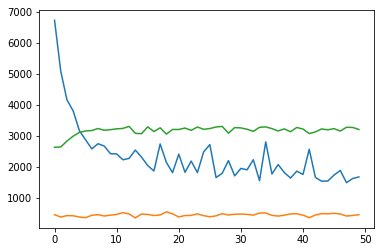

1


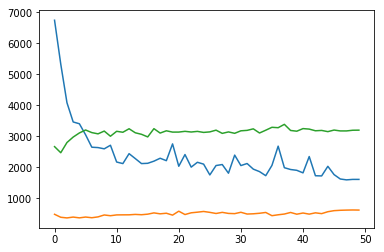

2


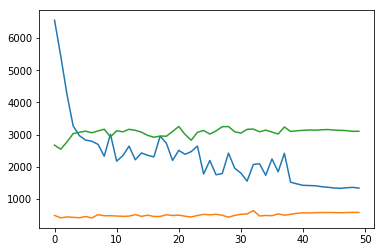

3


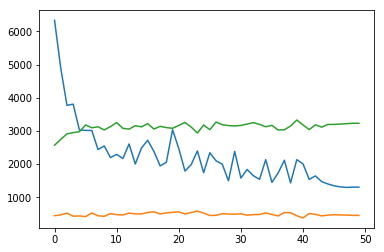

4


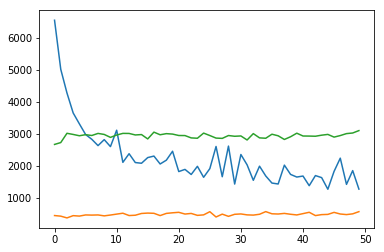

5


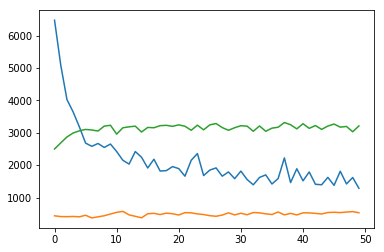

6


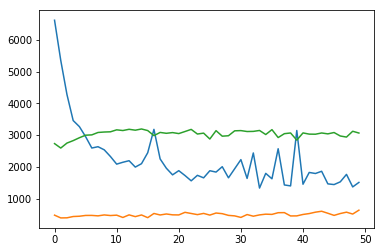

7


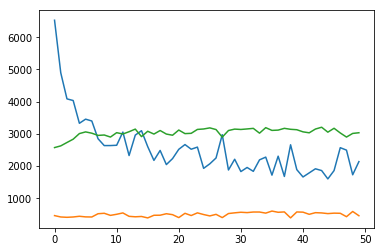

8


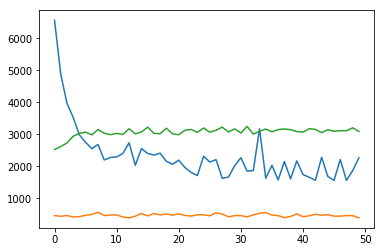

9


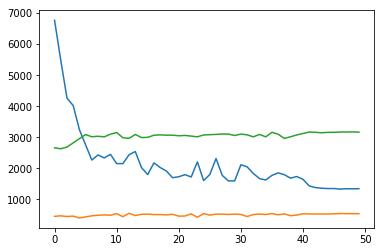

10


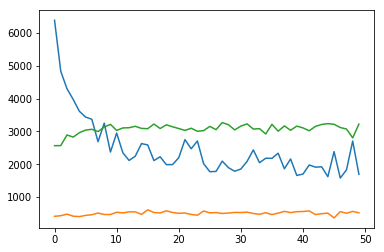

11


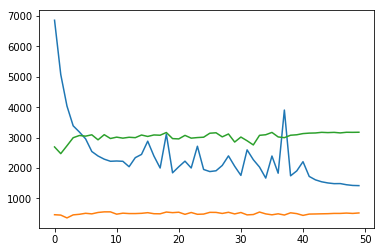

12


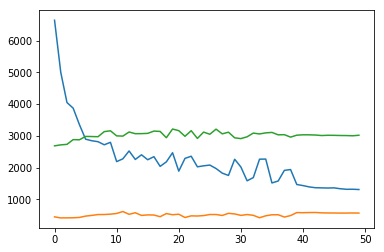

13


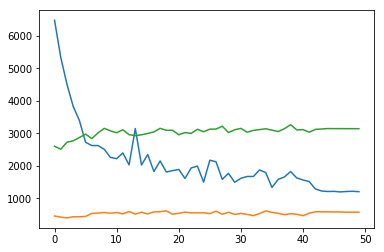

14


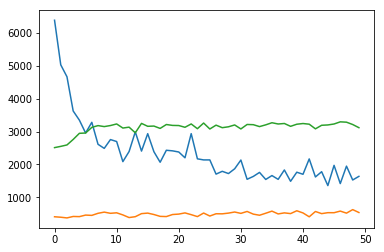

15


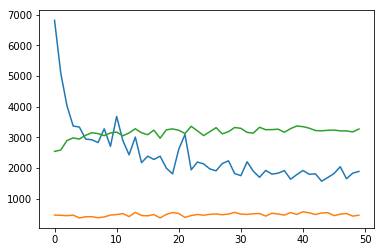

16


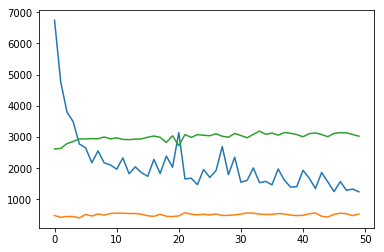

17


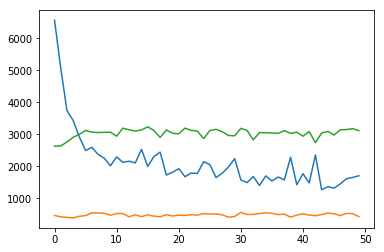

18


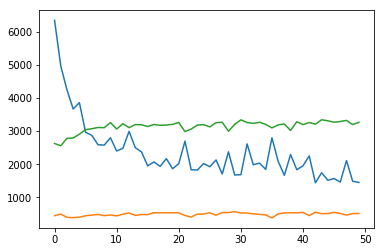

19


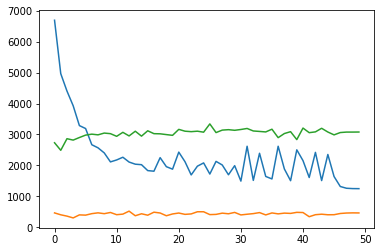

20


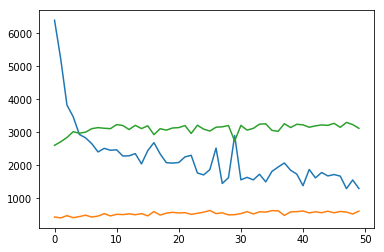

21


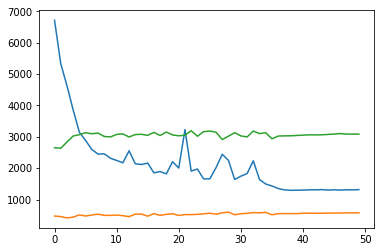

22


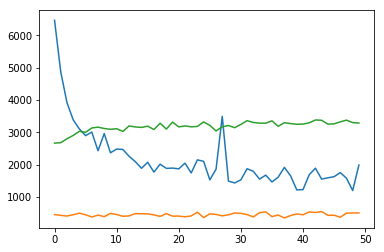

23


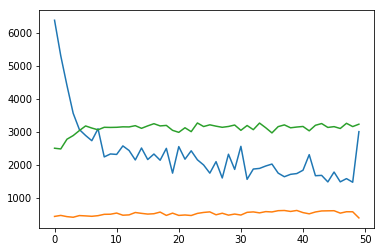

24


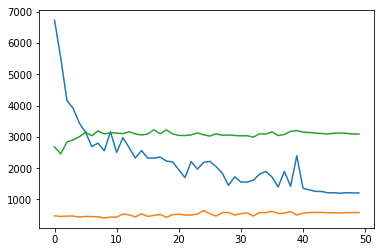

25


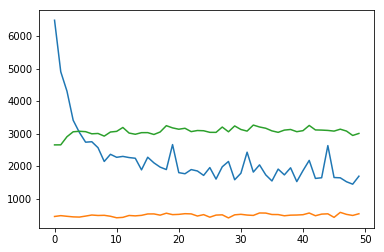

26


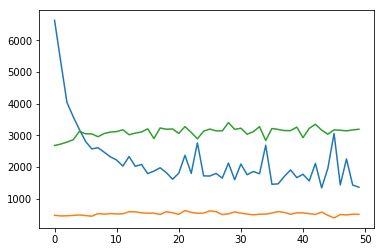

27


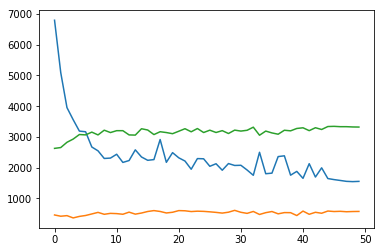

28


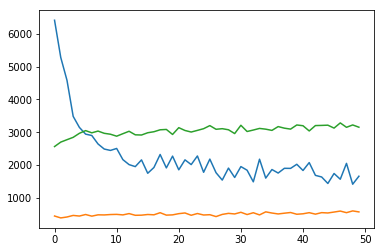

29


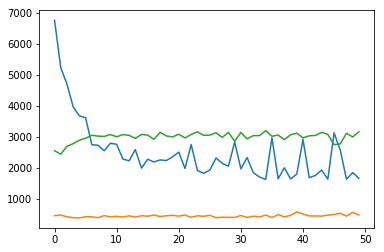

30


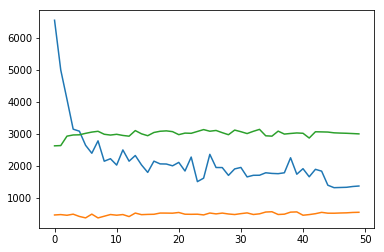

31


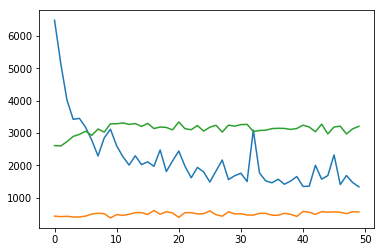

32


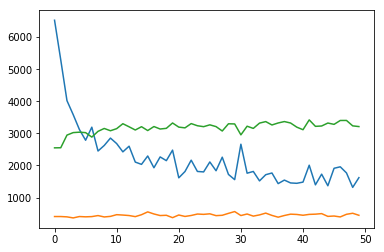

33


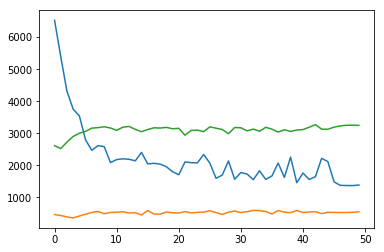

34


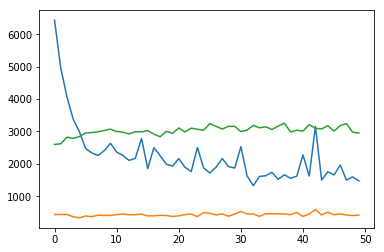

35


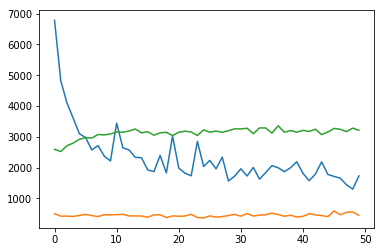

36


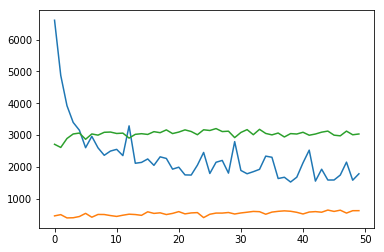

37


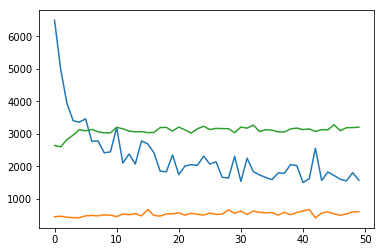

38


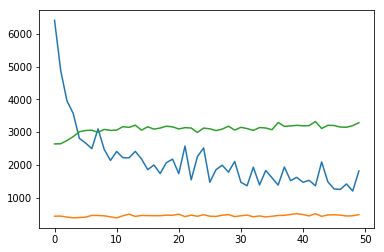

39


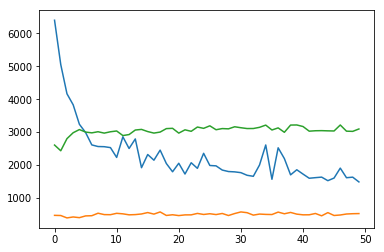

40


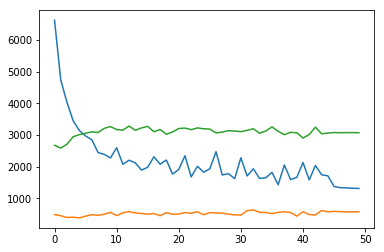

41


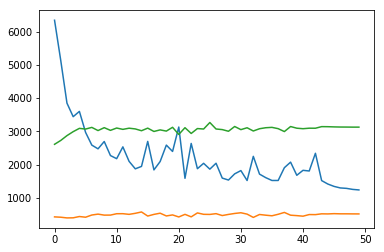

42


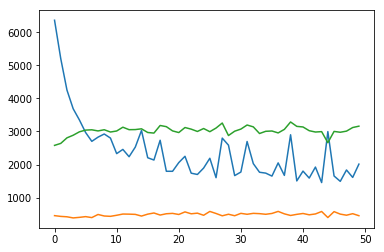

43


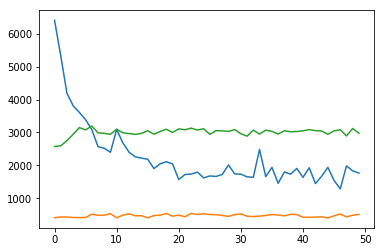

44


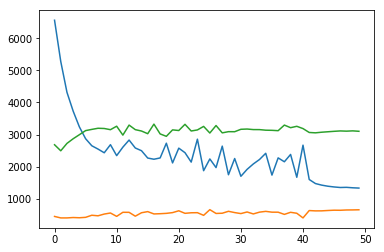

45


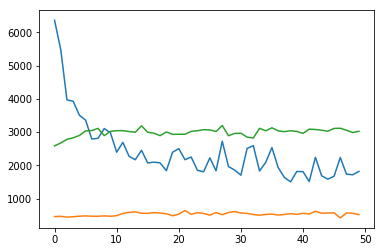

46


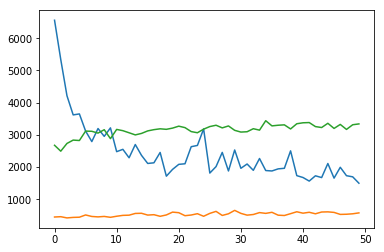

47


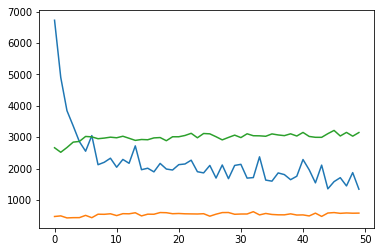

48


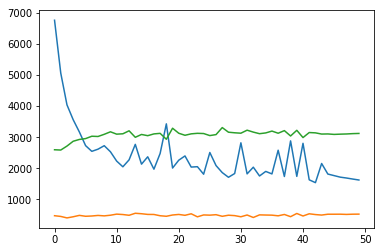

49


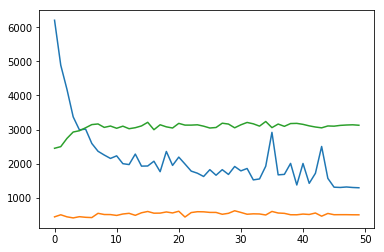

In [7]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


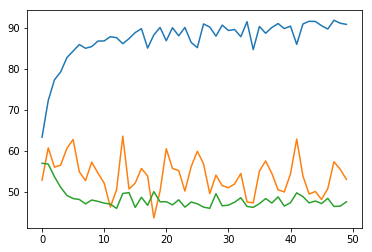

1


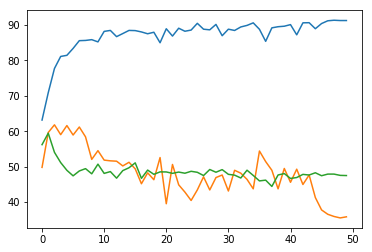

2


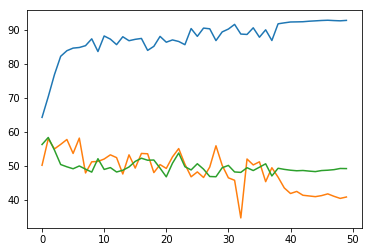

3


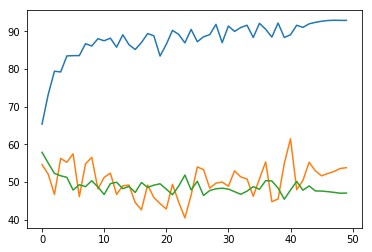

4


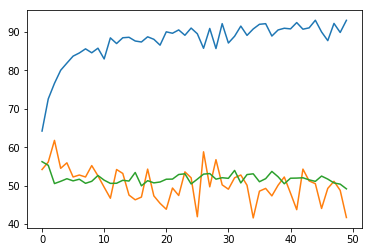

5


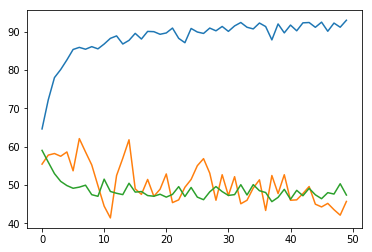

6


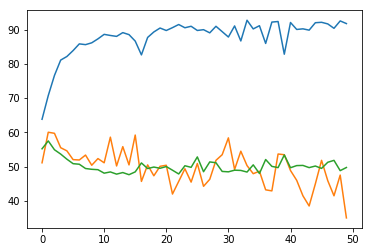

7


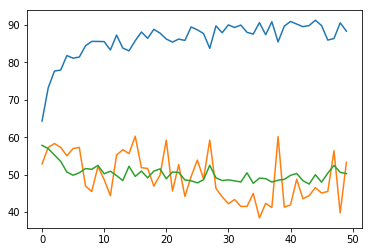

8


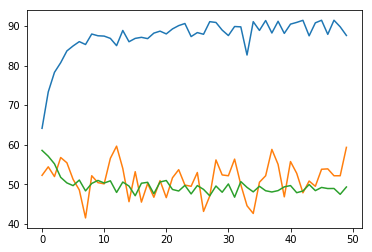

9


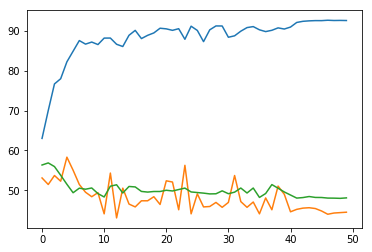

10


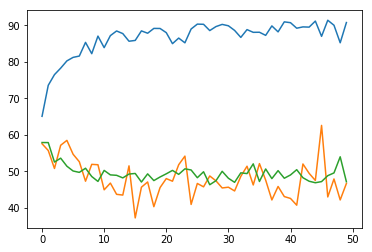

11


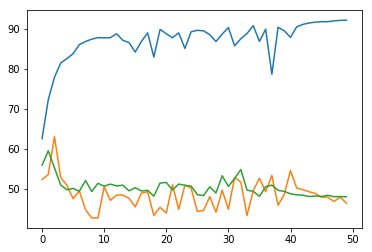

12


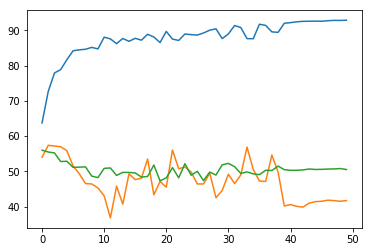

13


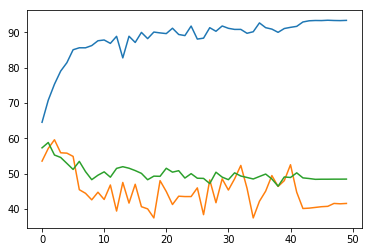

14


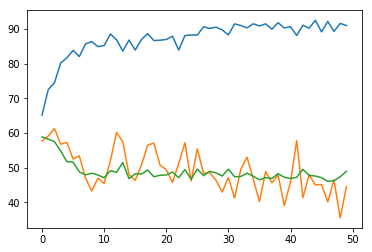

15


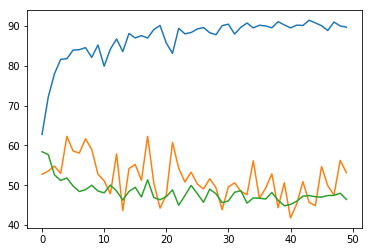

16


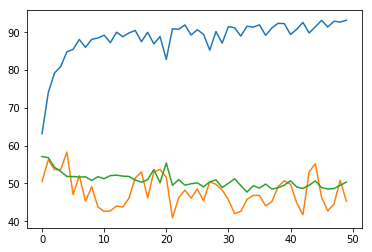

17


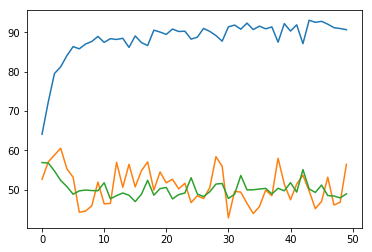

18


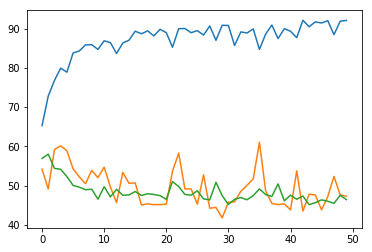

19


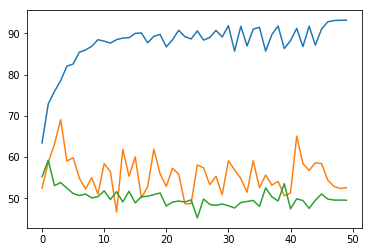

20


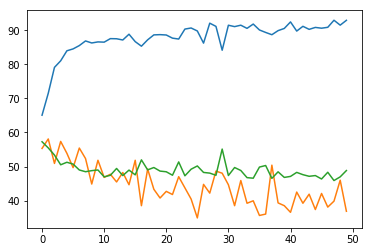

21


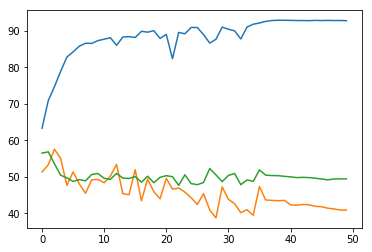

22


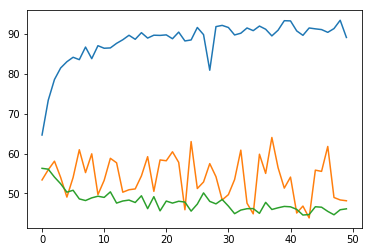

23


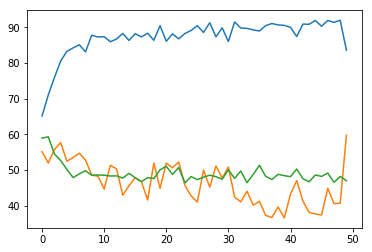

24


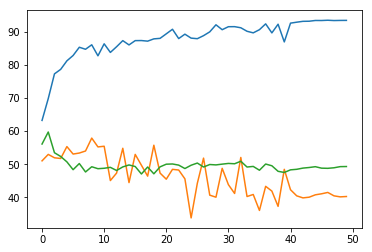

25


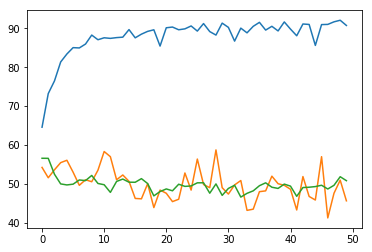

26


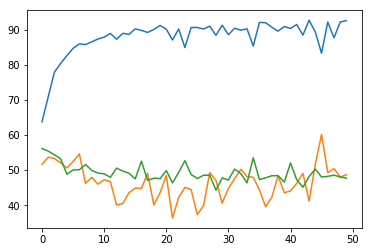

27


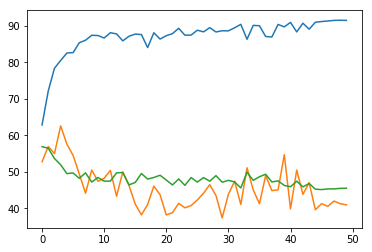

28


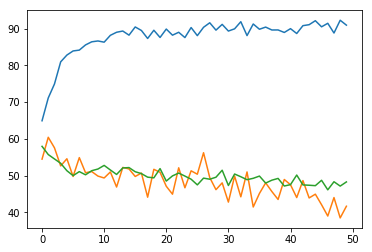

29


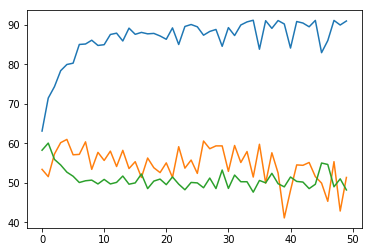

30


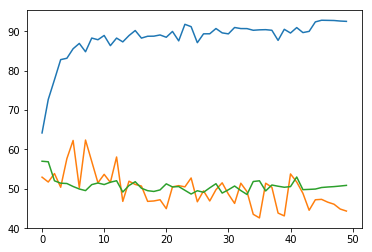

31


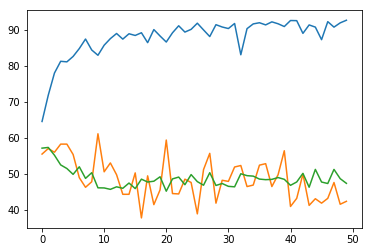

32


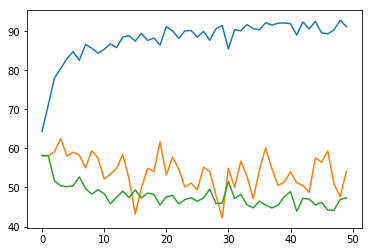

33


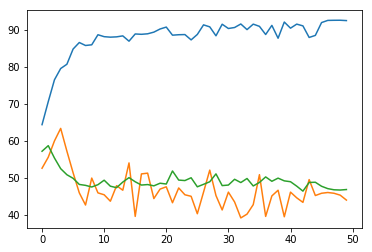

34


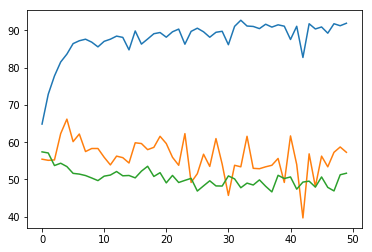

35


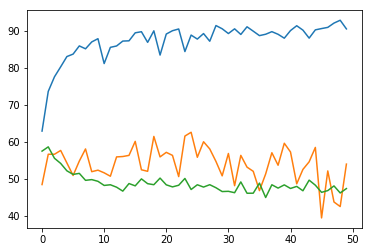

36


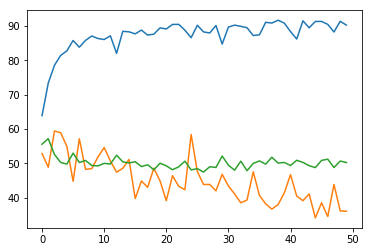

37


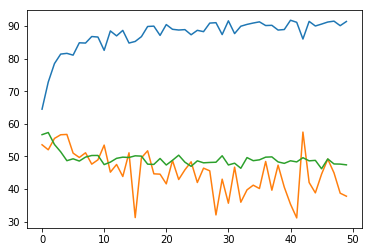

38


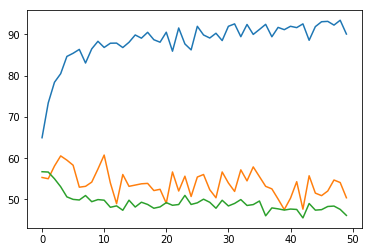

39


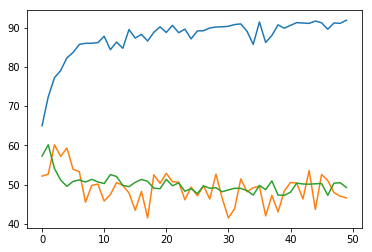

40


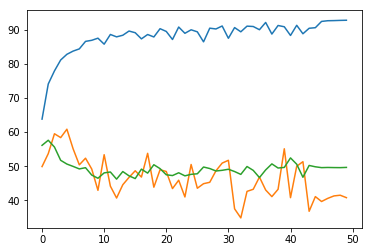

41


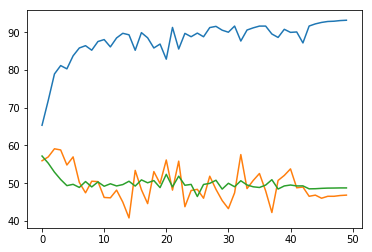

42


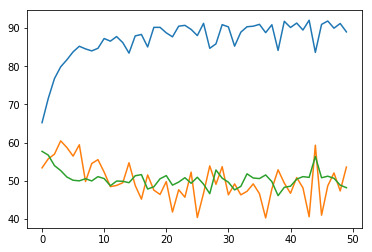

43


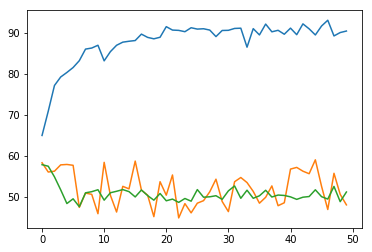

44


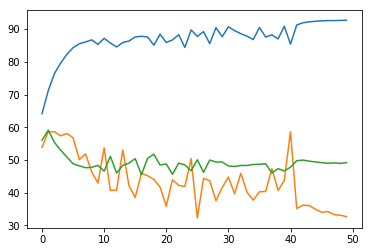

45


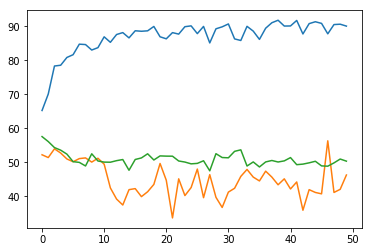

46


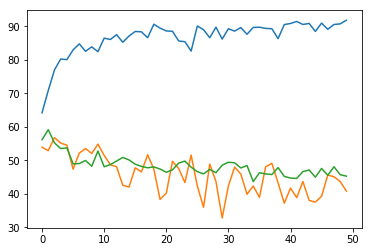

47


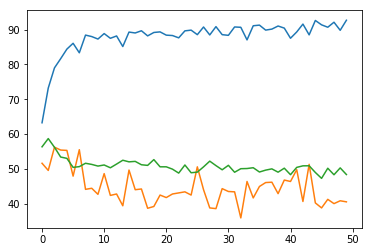

48


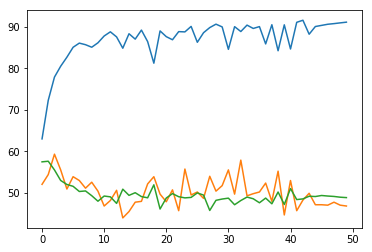

49


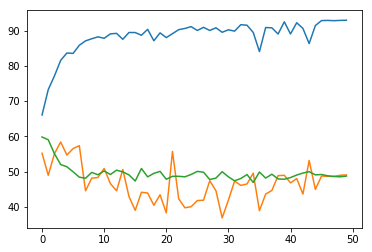

In [8]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

In [ ]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(75))
print(stddev_train_errors.shape)

plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
plt.errorbar(epoch, mean_test_errors, stddev_test_errors)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])